# MovieSum Data

We're exploring the new dataset given by Aida in hope to get more characters for moral character traits anchoring 20 latent dimensions.

In addition to that, we will create a pipeline that extracts all the dialogues spoken by characters and save them in json format.

After the processing, we will conduct the same 2 methods we did in analysis_1.ipynb.

In [1]:
import pandas as pd
import numpy as np
import torch
import json

import matplotlib.pyplot as plt

In [276]:
from datasets import load_dataset

ds = load_dataset("rohitsaxena/MovieSum")

Repo card metadata block was not found. Setting CardData to empty.


In [277]:
ds_train = ds["train"].to_pandas()
ds_val = ds["validation"].to_pandas()
ds_test = ds["test"].to_pandas()

In [278]:
ds = pd.concat([ds_train, ds_val, ds_test], ignore_index=True)

In [279]:
ds.shape

(2200, 4)

In [6]:
original_movie_data = pd.read_csv("../data/movies.csv")

In [29]:
original_movie_data.columns

Index(['movie', 'script', 'date', 'genres', 'first_genre', 'mfd_count',
       'rank'],
      dtype='object')

In [52]:
original_movie_data[original_movie_data["movie"] == "Zootopia"]["script"].values[0]

'\r\n\r\n\r\n\r\n                            ZOOTOPIA\r\n\r\n\r\n\r\n\r\n                           Written by\r\n\r\n                    Jared Bush & Phil Johnston\r\n\r\n\r\n\r\n\r\n                                                                     Story by\r\n                                                     Byron Howard, Rich Moore,\r\n                                      Jared Bush, Jim Reardon, Josie Trinidad,\r\n                                                Phil Johnston and Jennifer Lee\r\n\r\n\r\n\r\n   IN BLACK --\r\n\r\n   We hear the feral, primeval sounds of a jungle at night. A\r\n   timpani bangs an ominous beat.\r\n\r\n   FADE IN ON:\r\n\r\n\r\n   A JUNGLE - NIGHT\r\n\r\n   A BUNNY nervously walks through the dark, foreboding forest,\r\n   frightened by every shadow and moving leaf.\r\n\r\n                    YOUNG JUDY (V.O.)\r\n          Fear. Treachery. Bloodlust!\r\n          Thousands of years ago, these were\r\n          the forces that ruled our world. A\

In [61]:
print(original_movie_data[original_movie_data["movie"] == "Zootopia"]["script"].values[0])





                            ZOOTOPIA




                           Written by

                    Jared Bush & Phil Johnston




                                                                     Story by
                                                     Byron Howard, Rich Moore,
                                      Jared Bush, Jim Reardon, Josie Trinidad,
                                                Phil Johnston and Jennifer Lee



   IN BLACK --

   We hear the feral, primeval sounds of a jungle at night. A
   timpani bangs an ominous beat.

   FADE IN ON:


   A JUNGLE - NIGHT

   A BUNNY nervously walks through the dark, foreboding forest,
   frightened by every shadow and moving leaf.

                    YOUNG JUDY (V.O.)
          Fear. Treachery. Bloodlust!
          Thousands of years ago, these were
          the forces that ruled our world. A
          world where prey were scared of
          predators. And predators had an
          uncontrollable biologica

## Utterances extraction pipeline

In [7]:
with open("..//data//dialogue.json", "r") as f:
    original_movie_data = json.load(f)

Let's extract all the sentences from each character in each movie from the new movie dataset

### Helper functions

In [8]:
import re
from collections import defaultdict

def extract_character_dialogues(script_text):
    # Find all tags of interest
    tags = re.findall(r"<(character|dialogue)>(.*?)</\1>", script_text, flags=re.DOTALL)

    character_dialogues = defaultdict(list)
    current_character = None

    for tag, content in tags:
        content = content.strip()
        if tag == "character":
            current_character = content
        elif tag == "dialogue" and current_character:
            character_dialogues[current_character].append(content)

    return character_dialogues

In [9]:
def sentence_count_histogram_plot(data, movie = None, title = None, xlabel = None, bins = 30):
    num_sentences_lst = []

    if movie:
        data = data[movie]
        
        for char, sentences in data.items():
            num_sent = len(sentences)
            num_sentences_lst.append(num_sent)

    else:
        for movie, characters in data.items():
            for char, sentences in characters.items():
                num_sent = len(sentences)
                num_sentences_lst.append(num_sent)


    plt.figure(figsize=(10, 6))
    plt.hist(num_sentences_lst, bins=bins, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [45]:
dct = {}

for i, row in ds.iterrows():
    movie = row["movie_name"]
    dct[movie] = extract_character_dialogues(row["script"])


We're checking the number of movies that exist in the new dataset but not in the old dataset and vice versa.

In [15]:
# Both of the below arrays are numpy.ndarrays
old_data_movies = original_movie_data.keys()
new_data_movies = ds["movie_name"].unique()

# The movies in new dataset contains the year separated by an underscore
f = np.vectorize(lambda x: x.split("_")[0])
new_data_movies = f(new_data_movies)

In [48]:
count = 0

for movie in ds["movie_name"].unique():
    for char, sentences in dct[movie].items():
        if len(sentences) >= 50:
            count += 1
            break
print(f"Number of movies with at least one character having 50+ sentences: {count}")

Number of movies with at least one character having 50+ sentences: 2167


In [16]:
missing_movies = list(old_data_movies) - list(new_data_movies)
extra_movies = list(new_data_movies) - list(old_data_movies)

In [39]:
all_movies = list(old_data_movies) + list(extra_movies)

In [40]:
len(all_movies)

2595

In [26]:
type(all_movies)

list

In [104]:
len(missing_movies)  # We lost 423 movies

423

In [105]:
len(extra_movies)   # We have 1461 new movies

1461

Let's check distribution of the character sentences count

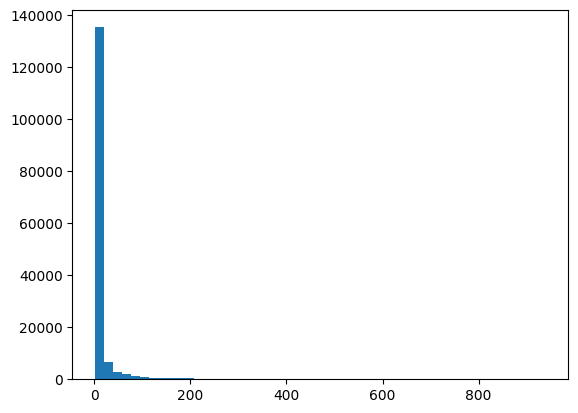

In [94]:
num_sent_lst = []

for movie, dialogues in dct.items():
    for character in dialogues:
        num_sent = len(dialogues[character])
        if num_sent == 0:
            print(f"Movie: {movie}, Character: {character} has no dialogues.")
            continue
        num_sent_lst.append(len(dialogues[character]))

plt.hist(num_sent_lst, bins=50)
plt.show()

Let's compare the distribution of the sentence counts for each character in the same movie to ensure they have the same sentences and one is not more reliable than the other. 

In [107]:
zootopia_old = original_movie_data["Zootopia"]
zootopia_new = dct["Zootopia_2016"]

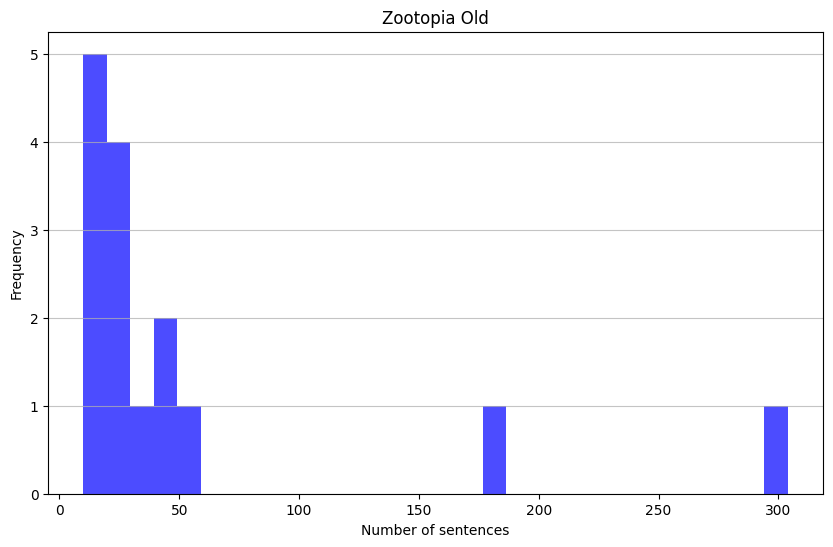

In [113]:
sentence_count_histogram_plot(original_movie_data, movie = "Zootopia", title="Zootopia Old", xlabel="Number of sentences")

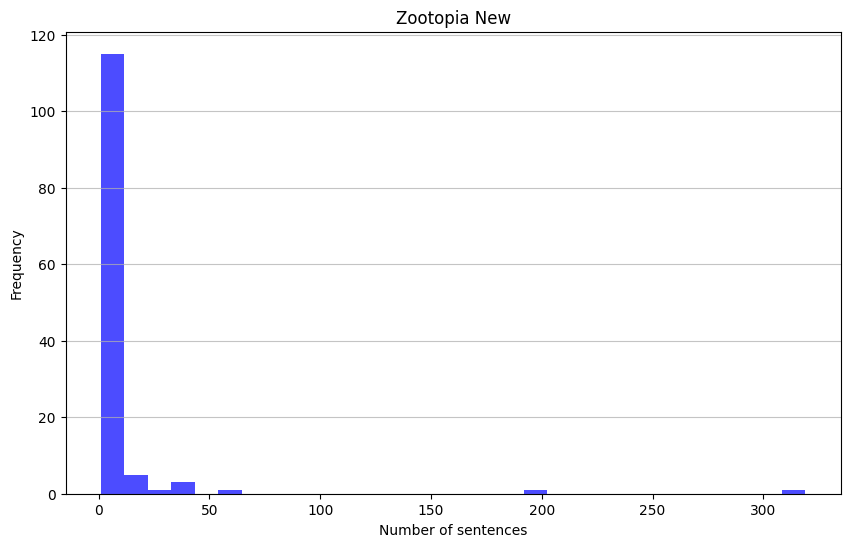

In [114]:
sentence_count_histogram_plot(dct, movie = "Zootopia_2016", title="Zootopia New", xlabel="Number of sentences")

The histograms are similar except for the fact that the new dataset seems to also store some insignicant characters the old dataset does not have. 

Therefore, the new dataset is good enough to use.

In [115]:
with open("..//data//new_dialogue.json", "w") as f:
    json.dump(dct, f, indent=4)

In [115]:
with open("..//data//new_dialogue.json", "r") as f:
    new_dialogue_data = json.load(f)

In [280]:
# Load the new moral only data
# We use this because the characters included here are the characters with at least 50 sentences containing moral word
with open("..//data//new_moral_only_data.json", "r") as f:
    new_moral_only_data = json.load(f)
    new_moral_only_data = new_moral_only_data["moral_dialogue"]

## Further data exploring

In [49]:
with open("..//data//new_moral_data_original.json", "r") as f:
    check_sentence_data = json.load(f)

In [297]:
count = 0

for movie, characters in new_moral_only_data.items():
    for character, sentences in characters.items():
            count += 1
print(f"Number of movies with at least one character having 50+ sentences: {count}")


# We check using new moral only data because all the characters in this data have at least 50 sentences

Number of movies with at least one character having 50+ sentences: 2448


In [282]:
count = 0
for char, data in new_moral_only_data["Superbad_2007"].items():
        count += 1
print(count)

2


In [283]:
count = 0
for k in check_sentence_data["moral_dialogue"].items():
    for char, items in k[1].items():
        if len(items) >= 70:
            count += 1

print(f"Number of characters with 50+ sentences in moral dialogue: {count}")

Number of characters with 50+ sentences in moral dialogue: 1370


In [52]:
count = 0
for k in dct.keys():
    if dct[k]:
        count += 1
print(f"Number of movies with at least one character having dialogues: {count}")

Number of movies with at least one character having dialogues: 2194


In [53]:
for k in dct.keys():
    if not dct[k]:
        print(f"Movie: {k} has no dialogues.")

Movie: It's Complicated_2009 has no dialogues.
Movie: Virtuosity_1995 has no dialogues.
Movie: Lock, Stock and Two Smoking Barrels_1998 has no dialogues.
Movie: Rushmore_1998 has no dialogues.
Movie: The Four Feathers_2002 has no dialogues.
Movie: Ali_2001 has no dialogues.


In [57]:
print(ds[ds["movie_name"] == "Lock, Stock and Two Smoking Barrels_1998"]["script"].values[0])

<script>
  <scene>
    <scene_description>Lock, Stock &amp; Two Smoking Barrels (1998) movie script by Guy Ritchie. Final script.</scene_description>
  </scene>
  <scene>
    <stage_direction>INT. INTERROGATION ROOM - PRESENT</stage_direction>
    <scene_description>This whole scene is shot using only extreme close-ups of eyes, cards, tapping fingers and mouths. We open on a bright pair of eyes. One is bruised and slightly swollen, but this does not detract from their clarity. EDDY Three card brag is a simple form of poker; you are dealt only three cards and these you can't change. If you don't look at your cards you're a 'blind man' and you only put in half the stake. Three of any kind is the highest you can get: the odds are four hundred and twenty- five to one. Then it's a running flush - you know, all the same suit running in order; then a straight, then a flush, then a pair, and finally whatever the highest card you are holding. There are some tell- tale signs that are valuable; I

## Analysis for Interpreting Latent Embeddings

In [292]:
len(new_latent_full)

2448

In [63]:
import pickle

with open("..//data/20d-embeddings/new-20_embeddings_full_default.pkl", "rb") as f:
    new_latent_full = pickle.load(f)

In [156]:
with open("..//data/20d-embeddings/new-bert-base_avg_sentence_embedding.pkl", "rb") as f:
    avg_bert_embedding_full = pickle.load(f)

In [66]:
file_path_1 = "..//data/SWCPQ-Features-Survey-Dataset-November2023//scripts//aggregated-means.csv"

data_1 = pd.read_csv(file_path_1, sep='\t')

data_1.rename(columns={'Unnamed: 0': 'character_code'}, inplace=True)

In [ ]:
from rapidfuzz import process, fuzz
import re

def normalize(title):
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)  # remove punctuation
    title = re.sub(r'\b(the|a|an)\b', '', title)  # optional: remove stop words
    title = re.sub(r'\s+', ' ', title).strip()  # remove extra whitespace
    return title

def get_similar_titles(set1, set2, threshold=85, set2_tuples = False):
    matched = []
    if set2_tuples:
        set2_normalized = [normalize(t[1]) for t in set2]
    else:
        set2_normalized = [normalize(t) for t in set2]

    for title1 in set1:
        title1_norm = normalize(title1)
        best_match = process.extractOne(title1_norm, set2_normalized, scorer=fuzz.token_sort_ratio)  # TO DO: check if this is the best approach
        if best_match and best_match[1] >= threshold:
            matched.append((title1, set2[set2_normalized.index(best_match[0])]))
    
    return matched

In [354]:
with open("..//data/SWCPQ-Features-Survey-Dataset-November2023//scripts//subjects.json", "r") as f:
    subjects = json.load(f)

movies_in_subjects = []
for subject in subjects:
    movies_in_subjects.append((subject, subjects[subject]["name"]))

In [359]:
# Try loading the full moral rating data

# Let's load the full moral rating data
file_path = "../data/SWCPQ-Features-Survey-Dataset-November2023/data files/features-survey-dataset.csv"

moral_rating_data = pd.read_csv(file_path, sep = "\t")

/var/folders/4p/8nlm0n094791rk0xf6jzk8ch0000gn/T/ipykernel_4230/1841787608.py:6: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  moral_rating_data = pd.read_csv(file_path, sep = "\t")


In [368]:
pairs

[('Superbad_2007_SETH', ('SB', 'Superbad')),
 ('Superbad_2007_EVAN', ('SB', 'Superbad')),
 ('Maleficent_2014_MALEFICENT', ('MAL', 'Maleficent')),
 ('Hustlers_2019_RAMONA', ('HUS', 'Hustlers')),
 ('Pulp Fiction_1994_JULES', ('PF', 'Pulp Fiction')),
 ('Pulp Fiction_1994_VINCENT', ('PF', 'Pulp Fiction')),
 ('Inception_2010_COBB', ('I', 'Inception')),
 ('Dexter_2006_DEXTER', ('D', 'Dexter')),
 ('The Breakfast Club_1985_BENDER', ('BC', 'The Breakfast Club')),
 ('Alien_1979_STANDARD', ('A', 'Alien')),
 ('The Hangover_2009_VICK', ('HO', 'The Hangover')),
 ('The Hangover_2009_STU', ('HO', 'The Hangover')),
 ('The Hangover_2009_ALAN', ('HO', 'The Hangover')),
 ('Death Note_2017_LUKE', ('DN', 'Death Note')),
 ('Groundhog Day_1993_PHIL', ('GHD', 'Groundhog Day')),
 ('Macbeth_2015_MACBETH', ('MCB', 'Macbeth')),
 ('Twilight_2008_BELLA', ('T', 'Twilight')),
 ('Twilight_2008_EDWARD', ('T', 'Twilight')),
 ('Little Women_2019_JO', ('LW', 'Little Women')),
 ('Jane Eyre_2011_JANE', ('JE', 'Jane Eyre')),


In [363]:
pd.set_option('display.max_columns', None)

moral_rating_data.head()

,universe_assigned,universe_knowledge,universe_lastseen,universe_rating,universes_selected,universes_unselected,gender,age_group,engNat,country,region,occupation,jung_type,enn_type,quiz_items,char_ratings,year,introelapse,testelapse,endelapse,surveyelapse,screen
0,HP,3,3,-1,HP,"TO,GOT,TW,L,PP,F,DS9,ALA,WW",2,2,2,IN,TN,UNEMPLOYED,NaN,NaN,"[[0, 28, 6, 19593], [1, 15, 66, 154985], [2, 2...","[[12, 5, 28, 21471], [15, 9, 60, 23446], [21, ...",2019,130,291,11,663,1
1,F,5,3,-1,F,"DS9,L,GOT,PP,TO,WW,HP,TW,ALA",2,3,1,US,CA,CAREGIVER,NaN,NaN,"[[0, 7, 29, 57681], [1, 20, 86, 11739], [2, 15...","[[1, 5, 69, 11217], [4, 28, 13, 6767], [2, 27,...",2019,109,138,8,263,2
2,HP,5,2,-1,"TO,F,HP","L,TW,ALA,PP,GOT,WW,DS9",2,1,1,US,OR,STUDENT,NaN,NaN,"[[0, 7, 7, 5887], [1, 8, 78, 3323], [2, 9, 40,...","[[23, 2, 96, 4969], [15, 14, 64, 4493], [27, 2...",2019,2,51,5,148,1
3,ALA,5,3,-1,"ALA,HP","F,TW,GOT,TO,WW,PP,DS9,L",2,2,1,GB,ENG,STUDENT,NaN,NaN,"[[0, 5, 55, 9836], [1, 20, 31, 3448], [2, 9, 6...","[[8, 2, 100, 3862], [10, 6, 74, 5533], [4, 11,...",2019,1081,60,5,151,1
4,ALA,3,3,-1,"ALA,HP","L,TW,PP,DS9,GOT,TO,F,WW",1,1,2,PH,00,STUDENT,NaN,NaN,"[[0, 28, 100, 8258], [1, 7, 2, 9135], [2, 19, ...","[[8, 19, 17, 7037], [5, 16, 63, 5858], [4, 1, ...",2019,23,60,4,175,2


In [367]:
moral_rating_movies = []

for movie in moral_rating_data:
    moral_rating_movies.append(moral_rating_movies[movie]["movie_name"])

TypeError: list indices must be integers or slices, not str

In [365]:
moral_rating_data.iloc[0]["quiz_items"]

'[[0, 28, 6, 19593], [1, 15, 66, 154985], [2, 20, 83, 20918], [3, 4, 58, 8885], [4, 9, 33, 8033], [5, 26, 47, 5827], [6, 19, 85, 9920], [7, 8, 83, 8124], [8, 5, 85, 5107]]'

In [366]:
moral_rating_data.iloc[0]["char_ratings"]

'[[12, 5, 28, 21471], [15, 9, 60, 23446], [21, 26, 36, 8310], [22, 19, 86, 10959], [23, 4, 62, 15797], [5, 13, 10, 21529], [19, 29, 40, 14283], [17, 21, 38, 14633], [6, 1, 67, 6212], [3, 20, 87, 7572], [8, 6, 96, 35475], [7, 15, 11, 6125], [16, 11, 100, 7986], [30, 28, 1, 4341], [2, 17, 84, 10100], [1, 24, 62, 9766], [4, 7, 77, 7319], [10, 8, 14, 10538], [20, 27, 75, 30921], [13, 14, 51, 15812], [24, 3, 84, 9569], [29, 12, 13, 6786], [26, 2, 68, 10318], [9, 30, 1, 25937], [27, 16, 62, 8714], [11, 25, 41, 6326], [25, 18, 21, 7241], [28, 22, 6, 7211], [18, 23, 39, 154130], [14, 10, 35, 13205]]'

In [351]:
subjects["GOT"].keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', 'N', 'name'])

In [357]:
count = 0
for subject in subjects:
    count += len(subjects[subject]) - 2
print(count)

2001


In [83]:
only_movies_in_subjects = [movie[1] for movie in movies_in_subjects]

In [275]:
len(only_movies_in_subjects)

341

In [358]:
len(new_latent_full)

2448

In [290]:
movies_chars_in_latent = []

for movie_char in new_latent_full.keys():
    parts = movie_char.rsplit("_", 1)
    movie = parts[0]  # in format <movie_name>_<year>
    char = parts[1]
    movies_chars_in_latent.append((movie, char))

movies_in_latent = []

for movie, char in movies_chars_in_latent:
    movie_to_add = movie.split("_")[0]  # Remove year from movie name
    if movie_to_add not in movies_in_latent:
        movies_in_latent.append(movie_to_add)  # Remove year from movie name

In [312]:
new_latent_full.keys()

dict_keys(['8MM_1999_WELLES', 'The Iron Lady_2011_MARGARET', 'Adventureland_2009_JAMES', 'Napoleon_2023_NAPOLEON', 'The Woman King_2022_NANISCA', 'What They Had_2018_BRIDGET', 'Synecdoche, New York_2008_CADEN', 'Superbad_2007_SETH', 'Superbad_2007_EVAN', 'The Guest_2014_DAVID', 'Backdraft_1991_STEPHEN', 'Backdraft_1991_BRIAN', 'Backdraft_1991_SHADOW', 'Maleficent_2014_MALEFICENT', "All the King's Men_2006_JACK", "All the King's Men_2006_WILLIE", 'Nine Days_2020_WILL', "Hangin' with the Homeboys_1991_VINNY", 'Selma_2014_KING', 'All About Eve_1950_EVE', 'All About Eve_1950_MARGO', 'All About Eve_1950_BILL', 'All About Eve_1950_ADDISON', 'Just Mercy_2019_BRYAN', 'Punch-Drunk Love_2002_BARRY', 'Fantastic Mr. Fox_2009_FOX', 'Rush_2013_JAMES', 'Made in Heaven_1987_MIKE', 'Toy Story 4_2019_WOODY', 'Dumb and Dumberer: When Harry Met Lloyd_2003_HARRY', 'Dumb and Dumberer: When Harry Met Lloyd_2003_LLOYD', 'Denial_2016_DEBORAH', 'The Best Exotic Marigold Hotel_2011_SONNY', 'The Third Man_1949_MA

In [80]:
movies_in_subjects

[('GOT', 'Game of Thrones'),
 ('HP', 'Harry Potter'),
 ('TO', 'The Office'),
 ('F', 'Friends'),
 ('WW', 'The West Wing'),
 ('L', 'LOST'),
 ('TW', 'The Wire'),
 ('ALA', 'Avatar: The Last Airbender'),
 ('DS9', 'Star Trek: Deep Space Nine'),
 ('PP', 'Pride and Prejudice'),
 ('MCU', 'Marvel Cinematic Universe'),
 ('S', 'The Simpsons'),
 ('T7S', "That 70's Show"),
 ('DA', 'Downton Abbey'),
 ('SW', 'Star Wars: Episode IV - A New Hope'),
 ('GA', 'Grey&apos;s Anatomy'),
 ('BB', 'Breaking Bad'),
 ('FS', 'Firefly + Serenity'),
 ('LOTR', 'Lord of the Rings'),
 ('C', 'Community'),
 ('WD', 'The Walking Dead'),
 ('BBT', 'The Big Bang Theory'),
 ('TD', 'True Detective'),
 ('PR', 'Parks and Recreation'),
 ('HG', 'The Hunger Games'),
 ('FC', 'Fight Club'),
 ('SC', 'Sex and the City'),
 ('D', 'Dexter'),
 ('DK', 'The Dark Knight'),
 ('WSW', 'Westworld'),
 ('LK', 'The Lion King'),
 ('CB', 'Casablanca'),
 ('BSG', 'Battlestar Galactica'),
 ('MM', 'Mad Men'),
 ('PC', 'Pirates of the Caribbean'),
 ('BVS', 'Bu

In [299]:
count =  0
movies_exist_in_both = []
for movie in movies_in_latent:
    if movie in only_movies_in_subjects:
        movies_exist_in_both.append(movie)
        count += 1

print(f"Number of movies in latent that are also in the SWCPQ dataset: {count}")

Number of movies in latent that are also in the SWCPQ dataset: 86


In [285]:
len(movies_exist_in_both)

86

In [104]:
movie_to_add

'Vacancy'

Here we're creating a list "pairs" containing pairs of character name in new_latent_full with its corresponding movie 

In [286]:
pairs = []

for movie_1 in new_latent_full.keys():          # The keys are in the format "MovieName_CharacterName"
    parts = movie_1.rsplit("_", 1)

    movie = parts[0]
    char = parts[1]

    movie_to_add = movie.split("_")[0]          # Remove year from movie name

    for movie_2 in movies_in_subjects:
        movie_2_name = movie_2[1]
        if movie_to_add == movie_2_name:  # You can adjust this threshold
            pairs.append((movie_1, movie_2))

In [347]:
len(movies_in_subjects)

341

In [369]:
with open("../data/new_dialogue.json", "r") as f:
    new_dialogue_data = json.load(f)

# Check if the characters in the pairs have dialogues in the new dialogue data
pairs = []

for movie_1 in new_dialogue_data.keys():          # The keys are in the format "MovieName_CharacterName"
    parts = movie_1.rsplit("_", 1)

    movie = parts[0]
    char = parts[1]

    movie_to_add = movie.split("_")[0]          # Remove year from movie name

    for movie_2 in movies_in_subjects:
        movie_2_name = movie_2[1]
        if movie_to_add == movie_2_name:  # You can adjust this threshold
            pairs.append((movie_1, movie_2))

In [370]:
len(pairs)

115

In [111]:
pairs

[('Superbad_2007_SETH', ('SB', 'Superbad')),
 ('Superbad_2007_EVAN', ('SB', 'Superbad')),
 ('Maleficent_2014_MALEFICENT', ('MAL', 'Maleficent')),
 ('Hustlers_2019_RAMONA', ('HUS', 'Hustlers')),
 ('Pulp Fiction_1994_JULES', ('PF', 'Pulp Fiction')),
 ('Pulp Fiction_1994_VINCENT', ('PF', 'Pulp Fiction')),
 ('Inception_2010_COBB', ('I', 'Inception')),
 ('Dexter_2006_DEXTER', ('D', 'Dexter')),
 ('The Breakfast Club_1985_BENDER', ('BC', 'The Breakfast Club')),
 ('Alien_1979_STANDARD', ('A', 'Alien')),
 ('The Hangover_2009_VICK', ('HO', 'The Hangover')),
 ('The Hangover_2009_STU', ('HO', 'The Hangover')),
 ('The Hangover_2009_ALAN', ('HO', 'The Hangover')),
 ('Death Note_2017_LUKE', ('DN', 'Death Note')),
 ('Groundhog Day_1993_PHIL', ('GHD', 'Groundhog Day')),
 ('Macbeth_2015_MACBETH', ('MCB', 'Macbeth')),
 ('Twilight_2008_BELLA', ('T', 'Twilight')),
 ('Twilight_2008_EDWARD', ('T', 'Twilight')),
 ('Little Women_2019_JO', ('LW', 'Little Women')),
 ('Jane Eyre_2011_JANE', ('JE', 'Jane Eyre')),


In [298]:
len(pairs)

144

We add the following to the pairs list -- these are the unidentical strings referring to the same movie. 

In [313]:
pairs

[('Superbad_2007_SETH', ('SB', 'Superbad')),
 ('Superbad_2007_EVAN', ('SB', 'Superbad')),
 ('Maleficent_2014_MALEFICENT', ('MAL', 'Maleficent')),
 ('Hustlers_2019_RAMONA', ('HUS', 'Hustlers')),
 ('Pulp Fiction_1994_JULES', ('PF', 'Pulp Fiction')),
 ('Pulp Fiction_1994_VINCENT', ('PF', 'Pulp Fiction')),
 ('Inception_2010_COBB', ('I', 'Inception')),
 ('Dexter_2006_DEXTER', ('D', 'Dexter')),
 ('The Breakfast Club_1985_BENDER', ('BC', 'The Breakfast Club')),
 ('Alien_1979_STANDARD', ('A', 'Alien')),
 ('The Hangover_2009_VICK', ('HO', 'The Hangover')),
 ('The Hangover_2009_STU', ('HO', 'The Hangover')),
 ('The Hangover_2009_ALAN', ('HO', 'The Hangover')),
 ('Death Note_2017_LUKE', ('DN', 'Death Note')),
 ('Groundhog Day_1993_PHIL', ('GHD', 'Groundhog Day')),
 ('Macbeth_2015_MACBETH', ('MCB', 'Macbeth')),
 ('Twilight_2008_BELLA', ('T', 'Twilight')),
 ('Twilight_2008_EDWARD', ('T', 'Twilight')),
 ('Little Women_2019_JO', ('LW', 'Little Women')),
 ('Jane Eyre_2011_JANE', ('JE', 'Jane Eyre')),


In [300]:
len(pairs)

144

In [372]:
pairs[0]

('Superbad_2007', ('SB', 'Superbad'))

In [379]:
structured_data = {}
similarity_threshold = 85
count = 0
count2 = 0
count3 = 0

for pair in pairs:
    dct = {}
    dct["subject_name"] = pair[1][1]  # The corresponding title in the subject.json of the movie
    dct["subject_code"] = pair[1][0]  # The corresponding code in the subject.json of the movie
    dct["characters"] = {}
    movie_name = pair[0].rsplit("_", 1)[0]
    if movie_name in structured_data:
        print(f"Movie {movie_name} already exists in structured_data. Skipping...")
        continue

    for char_index in subjects[pair[1][0]]:
        if char_index == "name" or char_index == "N":  # skip the name and n keys since they are not characters
            continue

        # Find the corresponding character name in moral_character_dict_100
        # We can use string similarity or find fraction of the character name
        character_subject_name = subjects[pair[1][0]][char_index]
        if isinstance(character_subject_name, list):  # Ensure it's a list before accessing the first element
            character_subject_name = character_subject_name[0]
        else:
            continue
        
        # Use substring matching to find the best match for the character name
        best_match = []
        
        # We should make sure the character here has at least 50 sentences in the new dialogue data
        for char_name, data in new_dialogue_data[pair[0]].items():
            if char_name.lower() in character_subject_name.lower():
                best_match = char_name  # Mock similarity score to pass the threshold
                count2 +=1
                break
            else:
                score = fuzz.token_sort_ratio(char_name.lower(), character_subject_name.lower())
                if score >= similarity_threshold:
                    best_match.append((char_name, score))
        
        if best_match:
            print(f"Found match for character: {character_subject_name} in movie: {pair[1][1]} with best match: {best_match}")
            count+=1
        else:
            print(f"No match found for character: {character_subject_name} in movie: {pair[1][1]}")
            continue
        
        # The below code is not reached even if the best_match is list
        # TODO: fix this if we want to use the best match from the list
        if isinstance(best_match, list) and len(best_match) > 0:
            # Sort the matches by similarity score and take the best one
            best_match = sorted(best_match, key=lambda x: x[1], reverse=True)[0][0]  # Get the character name with the highest score
            count += 1  # This does not add up the count, meaning we found all the match not here
        elif isinstance(best_match, list) and len(best_match) == 0:
            print(f"No match found for character: {character_subject_name} in movie: {pair[1][1]}")
            continue

        char_name = best_match
        # Once we find the character, we store the character code, name in dialogue data, name in subjects, rating, and the latent embeddings
        char_dct = {}

        char_dct["character_name"] = char_name

        # Use the corresponding character name to find the embedding
        char_dialogue_name = None

        char_dct["subject_name"] = character_subject_name

        char_dct["subject_code"] = pair[1][0] + "/" + str(char_index)

        rating_data = data_1[data_1["character_code"] == char_dct["subject_code"]]
        rating_data = rating_data.iloc[0].tolist()
        
        char_dct["rating"] = rating_data[1:]  # Skip the character_code column

        # Get the latent embeddings for the character
        name_in_latent = pair[0]

        # if name_in_latent in new_latent_full:
        #     char_dct["latent_full"] = new_latent_full[name_in_latent]

        # if name_in_latent in latent_moral_only:
        #     char_dct["latent_moral_only"] = latent_moral_only[name_in_latent]
        # else:
        #     char_dct["latent_moral_only"] = None

        char_dct["sentences"] = new_dialogue_data[pair[0]][char_name]

        # Store the data in dct["characters"][]
        count3 += 1
        # probably there are duplicates in the character names, so we overwrite the character data

        if char_name in dct["characters"]:
            print(f"Character {char_name} already exists in movie {movie_name}. Overwriting...")
        dct["characters"][char_name] = char_dct
        
    structured_data[movie_name] = dct

Found match for character: Seth in movie: Superbad with best match: SETH
Found match for character: Evan in movie: Superbad with best match: EVAN
Found match for character: Fogell (McLovin) in movie: Superbad with best match: FOGELL
Found match for character: Jules in movie: Superbad with best match: JULES
Found match for character: Becca in movie: Superbad with best match: BECCA
Found match for character: Officer Slater in movie: Superbad with best match: OFFICER SLATER
Found match for character: Maleficent in movie: Maleficent with best match: MALEFICENT
Found match for character: Destiny in movie: Hustlers with best match: DESTINY
Found match for character: Ramona Vega in movie: Hustlers with best match: RAMONA
Found match for character: Elizabeth in movie: Hustlers with best match: LIZ
Found match for character: Dominic Toretto in movie: Fast & Furious with best match: DOM
Found match for character: Brian O'Conner in movie: Fast & Furious with best match: BRIAN
Found match for char

In [385]:
count_sent = 0
count_char = 0

for movie, data in structured_data.items():
    for character, char_data in data["characters"].items():
        count_sent += len(char_data["sentences"])
        count_char += 1

In [387]:
print(len(structured_data)) 
print(count_sent)
print(count_char)

113
53179
392


In [393]:
count_sent = 0
count_char = 0

for movie, data in structured_data.items():
    for character, char_data in data["characters"].items():
        if len(char_data["sentences"]) >= 100:
            count_sent += len(char_data["sentences"])
            count_char += 1

In [394]:
print(len(structured_data)) 
print(count_sent)
print(count_char)

113
44162
201


In [395]:
with open("..//data/structured_data.json", "w") as f:
    json.dump(structured_data, f, indent=4)

In [389]:
print(count3)
print(count2)
print(count)


403
402
53583


Let's check the print output carefully to make sure there's no character name mismatch.

In [262]:
len(structured_data) 

87

In [346]:
num_characters = 0
num_movies = len(structured_data)

for movie, characters in structured_data.items():
    for character, sentences in characters["characters"].items():
        num_characters += 1
        num_sentences += len(sentences)

print(f'Total number of movies: {num_movies}')
print(f'Total number of characters: {num_characters}')

Total number of movies: 87
Total number of characters: 121


In [322]:
# Let's compare the characters in structured_data with those in pairs

missing_characters = []

for pair in pairs:
    movie_name, character_name = pair[0].rsplit("_", 1)
    if movie_name in structured_data:
        if character_name not in structured_data[movie_name]["characters"]:
            missing_characters.append((movie_name, character_name))
    else:
        missing_characters.append((movie_name, character_name))

print(f"Characters in pairs but not in structured_data: {missing_characters}")
print(f"Count of missing characters: {len(missing_characters)}")


Characters in pairs but not in structured_data: [('Alien_1979', 'STANDARD'), ('The Hangover_2009', 'VICK'), ('Death Note_2017', 'LUKE'), ('Fight Club_1999', 'JACK'), ('The Shape of Water_2017', 'STRICKLAND'), ('Baywatch_2017', 'BRODY'), ('Coco_2017', 'HÉCTOR'), ('The Curious Case of Benjamin Button_2008', "BENJAMIN BUTTON'S"), ('Gone Girl_2014', 'BONEY'), ('Supergirl_1984', 'SELENA'), ('Sense and Sensibility_1995', 'MRS. JENNINGS'), ('Promising Young Woman_2020', 'CASSANDRA'), ('Bad Boys_1995', 'BURNETT'), ('Bad Boys_1995', 'JULIE'), ('Green Book_2018', 'DR. SHIRLEY'), ("One Flew Over the Cuckoo's Nest_1975", 'BIG NURSE'), ('Silver Linings Playbook_2012', 'PAT SR.'), ('Hannibal_2001', 'STARLING'), ('Before Sunrise_1995', 'CELINE'), ('The Godfather_1972', 'DON CORLEONE'), ('Atomic Blonde_2017', 'PERCEVAL'), ('The Silence of the Lambs_1991', 'DR. LECTER'), ('Good Will Hunting_1997', 'LAMBEAU')]
Count of missing characters: 23


In [325]:
print("MISSING CHARACTERS:")
for pair in missing_characters:
    print(f"Movie: {pair[0]}, Character: {pair[1]}")

MISSING CHARACTERS:
Movie: Alien_1979, Character: STANDARD
Movie: The Hangover_2009, Character: VICK
Movie: Death Note_2017, Character: LUKE
Movie: Fight Club_1999, Character: JACK
Movie: The Shape of Water_2017, Character: STRICKLAND
Movie: Baywatch_2017, Character: BRODY
Movie: Coco_2017, Character: HÉCTOR
Movie: The Curious Case of Benjamin Button_2008, Character: BENJAMIN BUTTON'S
Movie: Gone Girl_2014, Character: BONEY
Movie: Supergirl_1984, Character: SELENA
Movie: Sense and Sensibility_1995, Character: MRS. JENNINGS
Movie: Promising Young Woman_2020, Character: CASSANDRA
Movie: Bad Boys_1995, Character: BURNETT
Movie: Bad Boys_1995, Character: JULIE
Movie: Green Book_2018, Character: DR. SHIRLEY
Movie: One Flew Over the Cuckoo's Nest_1975, Character: BIG NURSE
Movie: Silver Linings Playbook_2012, Character: PAT SR.
Movie: Hannibal_2001, Character: STARLING
Movie: Before Sunrise_1995, Character: CELINE
Movie: The Godfather_1972, Character: DON CORLEONE
Movie: Atomic Blonde_2017, 

In [263]:
for movie, movie_data in structured_data.items():
    for character in movie_data["characters"].keys():
        print(f"{movie} -- {character}")

Superbad_2007 -- SETH
Superbad_2007 -- EVAN
Maleficent_2014 -- MALEFICENT
Hustlers_2019 -- RAMONA
Pulp Fiction_1994 -- VINCENT
Pulp Fiction_1994 -- JULES
Inception_2010 -- COBB
Dexter_2006 -- DEXTER
The Breakfast Club_1985 -- BENDER
The Hangover_2009 -- STU
The Hangover_2009 -- ALAN
Groundhog Day_1993 -- PHIL
Macbeth_2015 -- MACBETH
Twilight_2008 -- BELLA
Twilight_2008 -- EDWARD
Little Women_2019 -- JO
Jane Eyre_2011 -- JANE
Jane Eyre_2011 -- ROCHESTER
Dune_1984 -- PAUL
The Perks of Being a Wallflower_2012 -- CHARLIE
Fight Club_1999 -- TYLER
The Last of the Mohicans_1992 -- HAWKEYE
Nomadland_2020 -- FERN
Jane Eyre_1943 -- JANE
Jane Eyre_1943 -- ROCHESTER
Gladiator_2000 -- MAXIMUS
Gladiator_2000 -- COMMODUS
Baywatch_2017 -- MITCH
Shrek_2001 -- SHREK
Shrek_2001 -- DONKEY
Coco_2017 -- MIGUEL
Die Hard_1988 -- MCCLANE
Die Hard_1988 -- HANS
The Curious Case of Benjamin Button_2008 -- BENJAMIN
The Curious Case of Benjamin Button_2008 -- DAISY
The Great Gatsby_2013 -- GATSBY
The Great Gatsby_2

In [317]:
print(count)

125


In [260]:
len(structured_data)

87

In [331]:
count = 0

for i in structured_data.keys():
    for char in structured_data[i]["characters"].keys():
        count += 1
print(count)

121


In [334]:
count = 0

for i in structured_data.keys():
    if len(structured_data[i]["characters"]) >= 1:
        for char in structured_data[i]["characters"].keys():
            if len(structured_data[i]["characters"][char]["rating"]) >= 1:
                count += 1
            else:
                print(f"Movie: {i}, Character: {char} has no rating.")
    else:
        print(f"Movie: {i} has no characters.")
print(count)

121


In [333]:
# Remove movies with no characters

movies_to_remove = [movie for movie, movie_data in structured_data.items() if len(movie_data["characters"]) == 0]

for movie in movies_to_remove:
    del structured_data[movie]

print(f"Removed {len(movies_to_remove)} movies with no characters.")

Removed 6 movies with no characters.


In [337]:
with open("..//data/structured_data.json", "w") as f:
    json.dump(structured_data, f, indent=4)

In [326]:
structured_data["Alien_1979"]

{'subject_name': 'Alien', 'subject_code': 'A', 'characters': {}}

In [212]:
structured_data["Superbad_2007"]

{'subject_name': 'Superbad',
 'subject_code': 'SB',
 'characters': {'SETH': {'character_name': 'SETH',
   'subject_name': 'Seth',
   'subject_code': 'SB/1',
   'rating': [29.4,
    72.3,
    50.6,
    38.9,
    73.6,
    15.0,
    54.8,
    69.7,
    74.3,
    61.2,
    55.5,
    36.9,
    85.3,
    32.7,
    85.1,
    77.6,
    24.2,
    31.8,
    32.1,
    75.1,
    34.7,
    35.7,
    74.0,
    41.0,
    65.4,
    81.5,
    17.3,
    43.2,
    32.7,
    37.8,
    24.4,
    68.4,
    14.8,
    16.0,
    20.4,
    18.6,
    29.7,
    19.9,
    46.8,
    70.5,
    74.6,
    13.9,
    74.3,
    14.0,
    42.0,
    30.9,
    32.9,
    36.8,
    78.3,
    83.3,
    77.6,
    41.0,
    52.9,
    45.1,
    62.9,
    60.8,
    24.1,
    28.7,
    22.6,
    86.7,
    66.1,
    63.3,
    63.0,
    25.8,
    63.8,
    61.1,
    19.7,
    32.7,
    76.6,
    16.9,
    77.4,
    28.4,
    25.3,
    79.4,
    16.9,
    29.9,
    14.9,
    24.5,
    21.5,
    50.9,
    69.6,
    60.2,
    78.5,
   

In [215]:
# Let's save the structured data to a JSON file

# When dumping, tell json how to handle Tensors:
with open("../data/structured_data.json", "w") as f:
    json.dump(
        structured_data,
        f,
        indent=4,
        default=lambda o: o.tolist() if isinstance(o, torch.Tensor) else None
    )

In [188]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def analyze_latent_components(char_to_latents, top_k=5):
    # Step 1: Compute mean latent for each character
    char_to_mean = {
        char: latents.mean(dim=0).numpy() for char, latents in char_to_latents.items()
    }

    # Stack into (num_chars, 20)
    char_names = list(char_to_mean.keys())
    all_means = np.stack([char_to_mean[char] for char in char_names])  # shape (N, 20)

    # Step 2: Plot histograms in 5x4 grid
    fig, axes = plt.subplots(5, 4, figsize=(20, 15))
    axes = axes.flatten()

    print("🔍 5 most extreme characters by latent dimension:\n")

    for i in range(20):
        ax = axes[i]
        values = all_means[:, i]
        ax.hist(values, bins=30, color='skyblue', edgecolor='black')
        ax.set_title(f"Latent dim {i}")

        # Step 3: Extract top-k and bottom-k characters
        sorted_indices = np.argsort(values)
        bottom = [(char_names[j], values[j]) for j in sorted_indices[:top_k]]
        top = [(char_names[j], values[j]) for j in sorted_indices[-top_k:]]

        print(f"Latent {i}:")
        print("  ⬇️ Lowest:")
        for name, val in bottom:
            print(f"    {name}: {val:.4f}")
        print("  ⬆️ Highest:")
        for name, val in reversed(top):
            print(f"    {name}: {val:.4f}")
        print()

    plt.tight_layout()
    plt.show()


Before proceeding, let's get the mean (and maybe standard deviation) of the latent sentence embeddings of each character. This is important as we can not do the correlation for all the sentences by each character (we need a single 20-dimensional embedding representing each character)

In [150]:
for movie, movie_data in structured_data.items():
    for character, char_data in movie_data["characters"].items():
        # Compute the mean of latent_full if it exists
        if char_data.get("latent_full") is not None:
            char_data["latent_full_mean"] = char_data["latent_full"].mean(dim=0).tolist()

### Begin our analysis

Using our new dataset, we'll be using the old and new models. We still use the old model (not the one hot one) because it seems to perform better compared to the new model. 

In [151]:
from scipy.stats import spearmanr

def method_1(structured_data, moral_only=False):
    latent_key = "latent_moral_only_mean" if moral_only else "latent_full_mean"

    latent_list = []
    rating_list = []

    for movie_dict in structured_data.values():
        for char_dict in movie_dict["characters"].values():
            latent = char_dict.get(latent_key)
            rating = char_dict.get("rating")

            # Only process if both latent and rating exist
            if latent is not None and rating is not None:
                latent_tensor = torch.tensor(latent)
                rating_tensor = torch.tensor(rating)
                latent_list.append(latent_tensor)
                rating_list.append(rating_tensor)

    latent_matrix = torch.stack(latent_list).numpy()   # shape: [n_characters, 20]
    rating_matrix = torch.stack(rating_list).numpy()   # shape: [n_characters, 500]

    num_latent, num_traits = latent_matrix.shape[1], rating_matrix.shape[1]
    correlation_matrix = np.zeros((num_latent, num_traits))

    for i in range(num_latent):
        for j in range(num_traits):
            x = latent_matrix[:, i]
            y = rating_matrix[:, j]
            if np.std(x) == 0 or np.std(y) == 0:
                correlation_matrix[i, j] = np.nan
            else:
                corr, _ = spearmanr(x, y)
                correlation_matrix[i, j] = corr

    correlation_df = pd.DataFrame(
        correlation_matrix,
        index=[f"latent_{i}" for i in range(num_latent)],
        columns=[f"trait_{j}" for j in range(num_traits)]
    )

    return correlation_df

### New model

Analysis 1

In [152]:
correlation_df_full = method_1(structured_data, moral_only=False)

top_k = 5

for i in range(correlation_df_full.shape[0]):
    latent_name = correlation_df_full.index[i]
    top_traits = correlation_df_full.loc[latent_name].abs().nlargest(top_k)
    print(f"\nTop {top_k} traits for {latent_name}:")
    for trait_name, corr_value in correlation_df_full.loc[latent_name][top_traits.index].items():
        print(f"{trait_name}: {corr_value:.3f}")


Top 5 traits for latent_0:
trait_152: 0.443
trait_189: -0.346
trait_110: 0.338
trait_108: -0.332
trait_263: -0.323

Top 5 traits for latent_1:
trait_108: -0.296
trait_110: 0.295
trait_85: 0.261
trait_81: -0.251
trait_417: 0.237

Top 5 traits for latent_2:
trait_85: -0.401
trait_343: 0.368
trait_93: -0.365
trait_476: -0.365
trait_224: -0.346

Top 5 traits for latent_3:
trait_334: 0.325
trait_169: -0.318
trait_85: 0.312
trait_3: 0.299
trait_191: 0.290

Top 5 traits for latent_4:
trait_326: -0.318
trait_85: -0.273
trait_334: -0.243
trait_417: -0.239
trait_61: -0.236

Top 5 traits for latent_5:
trait_152: -0.380
trait_206: 0.370
trait_208: -0.314
trait_189: 0.312
trait_110: -0.277

Top 5 traits for latent_6:
trait_334: -0.313
trait_85: -0.296
trait_191: -0.291
trait_343: 0.285
trait_93: -0.284

Top 5 traits for latent_7:
trait_108: 0.356
trait_152: -0.355
trait_85: -0.344
trait_110: -0.336
trait_343: 0.293

Top 5 traits for latent_8:
trait_206: 0.288
trait_208: -0.252
trait_24: 0.243
trai

🔍 5 most extreme characters by latent dimension:

Latent 0:
  ⬇️ Lowest:
    Mid90s_2018_STEVIE: -0.0673
    Beautiful Boy_2018_NIC: -0.0557
    The Climb_2019_KYLE: -0.0459
    Sound of Metal_2019_RUBEN: -0.0410
    Me Him Her_2015_GABBI: -0.0361
  ⬆️ Highest:
    Romeo + Juliet_1996_JULIET: 0.5913
    Macbeth_2015_MACBETH: 0.5875
    The Tragedy of Macbeth_2021_MACBETH: 0.5731
    Romeo + Juliet_1996_ROMEO: 0.5717
    Coriolanus_2014_CORIOLANUS: 0.5121

Latent 1:
  ⬇️ Lowest:
    Corpse Bride_2005_\*: -0.2673
    The Killer_2023_CONTINUED: -0.2430
    Coriolanus_2014_CORIOLANUS: -0.1910
    Cecil B. Demented_2000_CECIL: -0.1880
    Moby Dick_1956_AHAB: -0.1837
  ⬆️ Highest:
    Sling Blade_1996_FRANK: 0.2652
    Driving Miss Daisy_1989_HOKE: 0.2135
    Sling Blade_1996_KARL: 0.2056
    Roughshod_1949_CLAY: 0.1692
    Rocky_1976_ROCKY: 0.1658

Latent 2:
  ⬇️ Lowest:
    Sense and Sensibility_1995_MRS. JENNINGS: -0.5257
    Sweeney Todd: The Demon Barber of Fleet Street_2007_MRS. LOVET

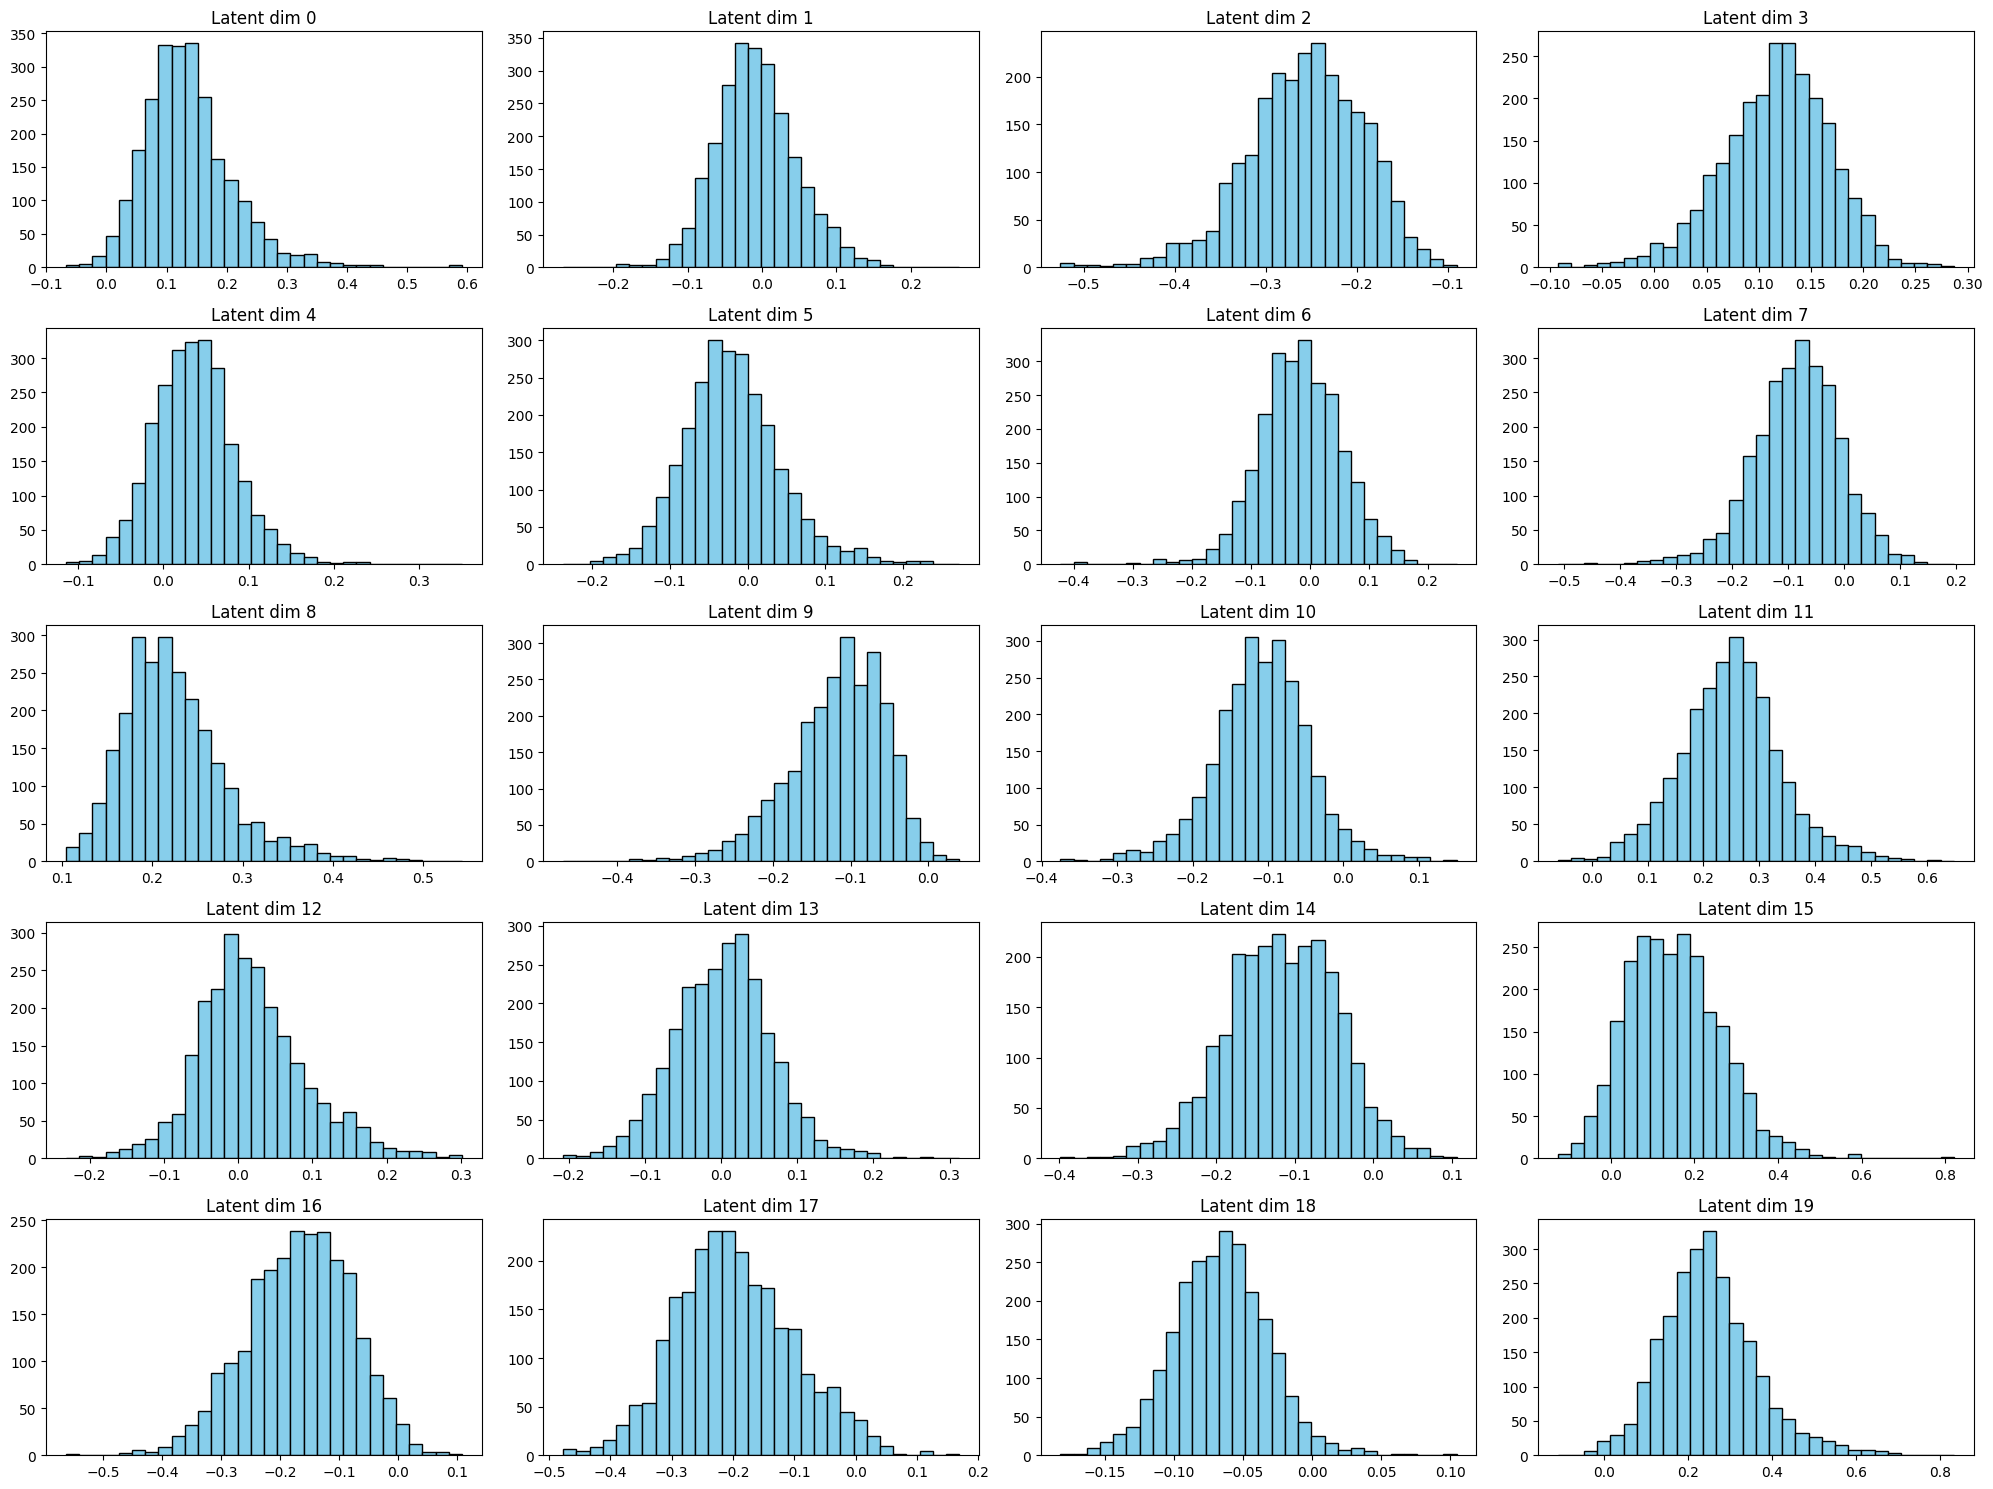

In [189]:
analyze_latent_components(new_latent_full, top_k=5)

Correlations with largest absolute value:
### Trait 85 (Direct/Roundabout) and Latent 2:

Lowest (Roundabout speakers):
These characters often use indirect, emotional, or florid language:

- Mrs. Jennings – Sense and Sensibility: A gossipy, talkative woman who often speaks in a roundabout and meddlesome way.

- Mrs. Lovett – Sweeney Todd: Speaks with euphemism and humor to mask darker motives. Talks in long-winded, cheeky ways.

- Hoke – Driving Miss Daisy: Polite, careful, and often beats around the bush, especially early on.

- Juliet – Romeo + Juliet: Poetic, metaphorical, and romantic language—classic roundabout expression.

- Merrick – The Elephant Man: Sensitive, formal, and often speaks carefully or hesitantly.

Highest (Direct speakers):
These characters speak with clarity, efficiency, and minimal fluff:

- STEM (V.O.) – Upgrade: An AI system that gives precise, logical instructions—pure directness.

- Eric – The Rover: Gruff and straight to the point, often blunt and emotionless.

- Kate – Kate: A no-nonsense assassin with clipped, practical dialogue.

- Max – Geostorm: Technical, to-the-point, and focused on giving mission-critical info.

- Nancy – The Mauritanian: A defense lawyer who likely speaks with clarity and control, especially in legal arguments.







### Trait 152 (Philosophical/Real) and Latent 0:

Lowest values (more real, less philosophical?):
- Mid90s_2018_STEVIE: A troubled, vulnerable preteen navigating a rough environment. Very grounded and raw.

- Beautiful Boy_2018_NIC: A teenager struggling with addiction; very emotionally raw and realistic.

- The Climb_2019_KYLE: A man dealing with friendship and loyalty in a down-to-earth, flawed way.

- Sound of Metal_2019_RUBEN: A drummer forced to confront his hearing loss; deeply grounded in real-world struggles.

- Me Him Her_2015_GABBI: Involved in personal, identity-based issues—not abstract philosophy.

Highest values (more philosophical?):
- Romeo + Juliet_1996_JULIET & ROMEO: Idealistic, poetic lovers—classic examples of romanticized, philosophical thinking about love and fate.

- Macbeth_2015_MACBETH & The Tragedy of Macbeth_2021_MACBETH: Obsessed with ambition, destiny, and moral philosophy (e.g., free will vs. fate).

- Coriolanus_2014_CORIOLANUS: A prideful character often engaged in political and moral dilemmas

There are no outstanding correlations.

Analysis 2

In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def method_2(structured_data, moral_only=False):
    latent_key = "latent_moral_only_mean" if moral_only else "latent_full_mean"

    latent_list = []
    rating_list = []

    for movie_dict in structured_data.values():
        for char_dict in movie_dict["characters"].values():
            latent = char_dict.get(latent_key)
            rating = char_dict.get("rating")

            if latent is not None and rating is not None:
                latent_tensor = torch.tensor(latent)
                rating_tensor = torch.tensor(rating)
                latent_list.append(latent_tensor)
                rating_list.append(rating_tensor)

    X = torch.stack(latent_list).numpy()   # shape: [n_characters, 20]
    Y = torch.stack(rating_list).numpy()   # shape: [n_characters, 500]

    n_traits = Y.shape[1]
    latent_dim = X.shape[1]

    rows = []

    for j in range(n_traits):
        y = Y[:, j]
        if np.std(y) == 0:
            row = {"trait_index": f"trait_{j}", "r2_score": np.nan}
            row.update({f"latent_{k}": np.nan for k in range(latent_dim)})
            rows.append(row)
            continue

        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)

        row = {"trait_index": f"trait_{j}", "r2_score": r2}
        row.update({f"latent_{k}": coef for k, coef in enumerate(model.coef_)})
        rows.append(row)

    r2_df = pd.DataFrame(rows)
    return r2_df


In [193]:
r2_df_full = method_2(structured_data, moral_only=False)

# View top traits best explained by latent dimensions
r2_df_full.sort_values(by="r2_score", ascending=False).head(10)

,trait_index,r2_score,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,...,latent_10,latent_11,latent_12,latent_13,latent_14,latent_15,latent_16,latent_17,latent_18,latent_19
152,trait_152,0.290481,-788.134521,540.013550,258.681854,209.532425,-28.725372,-956.859619,-91.746811,516.527771,...,1664.130859,694.981750,1490.291016,251.476746,-212.278198,1227.245361,1230.405518,884.737366,588.197510,893.820435
206,trait_206,0.265414,1716.416260,-176.326172,-735.085938,-966.208130,650.092896,1494.656006,638.278137,-636.799438,...,-516.458923,-982.415894,-940.037170,356.434387,1529.008179,-2070.869873,-2058.272949,-1619.049927,-1214.470215,-1.733509
108,trait_108,0.253640,-960.828064,36.894226,1300.297729,-472.501282,452.287506,-1606.379272,-184.017380,802.232788,...,650.629578,-732.299622,375.926941,9.111872,-2211.727783,1915.559082,583.460510,-875.624451,1549.438965,294.250580
93,trait_93,0.249124,417.483582,-283.322906,-56.990753,583.615295,-641.973633,410.151276,-513.877808,-287.945953,...,-1755.502808,-112.408417,-1308.382202,-681.239624,-96.952789,-420.930206,-177.855835,7.762341,-736.123962,-1188.199829
264,trait_264,0.245160,29.277763,-925.515137,516.039795,-144.458771,53.786057,222.452820,8.062422,27.716785,...,-1800.902954,-226.775803,-214.827438,-486.988983,-1324.470215,-257.410461,737.492676,-421.828461,648.729309,-1159.207275
208,trait_208,0.243489,-2341.508545,-272.389709,2005.404663,614.785400,-524.538147,-2439.058350,-644.851624,1320.014404,...,490.573425,1000.400879,1627.864136,-386.280334,-3617.681396,3286.397217,3018.471436,1246.598999,2565.084473,-19.357033
85,trait_85,0.240878,454.628998,-342.524231,-646.678467,26.174221,-67.107323,825.030579,163.227829,-107.603111,...,-277.592407,576.986206,580.488220,-127.098427,740.582642,-804.637695,543.271973,547.006348,-313.398865,-195.487457
229,trait_229,0.235320,1064.192627,-20.845520,-714.818115,-36.525448,303.884308,667.571289,66.791595,-383.848969,...,-1378.916626,-581.543579,-1433.673950,-171.783920,1053.323242,-1348.053101,-850.432800,-509.952759,-888.396423,-977.618530
110,trait_110,0.233444,1200.625854,98.792053,-1908.930420,903.801270,-829.448303,2047.671753,-153.045258,-1252.955322,...,-1240.681519,478.190765,-1336.180420,-462.106903,2967.088379,-2201.809570,-1076.813965,966.486145,-2345.430908,-847.457031
375,trait_375,0.222044,-91.384163,209.797073,-599.428772,215.763367,387.991486,268.975861,76.021599,-111.695152,...,283.095856,347.063995,380.425507,-127.099251,1069.244873,-642.411804,104.661201,566.189941,73.815544,-146.446533


In [198]:
r2_df_full[r2_df_full["trait_index"] == "trait_33"].sort_values(by="r2_score", ascending=False)

,trait_index,r2_score,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,...,latent_10,latent_11,latent_12,latent_13,latent_14,latent_15,latent_16,latent_17,latent_18,latent_19
33,trait_33,0.118261,-1239.567993,636.255066,1380.371826,389.800629,-239.196915,-1414.259155,174.33989,726.211731,...,2973.367676,-159.738205,1444.138794,698.238831,-1952.758301,2523.499756,1003.070496,46.885567,1341.047852,1837.052124


25
28
33

In [206]:
structured_data["Superbad_2007"]["characters"]['SETH']

{'character_name': 'SETH',
 'subject_name': 'Seth',
 'subject_code': 'SB/1',
 'rating': [29.4,
  72.3,
  50.6,
  38.9,
  73.6,
  15.0,
  54.8,
  69.7,
  74.3,
  61.2,
  55.5,
  36.9,
  85.3,
  32.7,
  85.1,
  77.6,
  24.2,
  31.8,
  32.1,
  75.1,
  34.7,
  35.7,
  74.0,
  41.0,
  65.4,
  81.5,
  17.3,
  43.2,
  32.7,
  37.8,
  24.4,
  68.4,
  14.8,
  16.0,
  20.4,
  18.6,
  29.7,
  19.9,
  46.8,
  70.5,
  74.6,
  13.9,
  74.3,
  14.0,
  42.0,
  30.9,
  32.9,
  36.8,
  78.3,
  83.3,
  77.6,
  41.0,
  52.9,
  45.1,
  62.9,
  60.8,
  24.1,
  28.7,
  22.6,
  86.7,
  66.1,
  63.3,
  63.0,
  25.8,
  63.8,
  61.1,
  19.7,
  32.7,
  76.6,
  16.9,
  77.4,
  28.4,
  25.3,
  79.4,
  16.9,
  29.9,
  14.9,
  24.5,
  21.5,
  50.9,
  69.6,
  60.2,
  78.5,
  46.5,
  41.2,
  59.9,
  32.5,
  27.1,
  28.3,
  77.4,
  45.8,
  27.8,
  53.5,
  81.7,
  15.0,
  80.3,
  65.7,
  64.5,
  68.7,
  49.1,
  20.3,
  59.6,
  57.6,
  69.1,
  35.7,
  58.4,
  56.0,
  40.4,
  56.9,
  31.4,
  58.9,
  54.4,
  54.4,
  48.3,
 

In [202]:
count = 0
for movie, characters in structured_data.items():
    for character, char_data in characters["characters"].items():
        count += 1
print(f"Total number of characters in structured_data: {count}")

Total number of characters in structured_data: 293


The top 10 traits explained by the latent dimensions:
- Trait 152: Philosophical/Real
- Trait 206: Deranged/Reasonable
- Trait 108: Sickly/Healthy
- Trait 93:  Hipster/Basic
- Trait 264: 🥾	/ 👟
- Trait 208: Introspective/Non-introspective
- Trait 85:  Direct/Roundabout
- Trait 229: Formal/Intimate
- Trait 110: Vain/Demure
- Trait 375: Princess/Queen


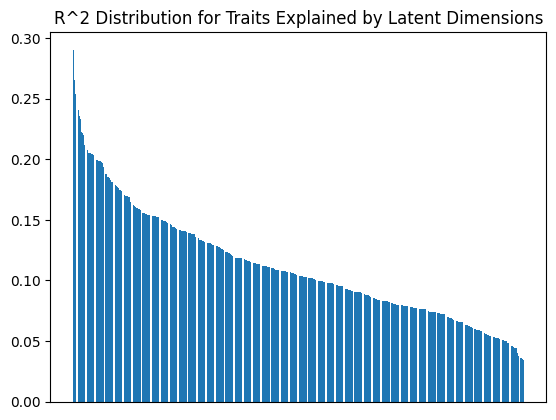

In [164]:
r2_df_full_sorted = r2_df_full.sort_values(by="r2_score", ascending=False)

plt.bar(r2_df_full_sorted["trait_index"], r2_df_full_sorted["r2_score"])
plt.xticks([])
plt.title("R^2 Distribution for Traits Explained by Latent Dimensions")
plt.show()

### Old model

In [165]:
### TO DO: Prepare the structured data for the old model

with open("..//data/20d-embeddings/new-20_embeddings_full_default_with_old_model.pkl", "rb") as f:
    old_latent_full = pickle.load(f)

In [170]:
structured_data_2 = {}
similarity_threshold = 85
count = 0

for pair in pairs:
    dct = {}
    dct["subject_name"] = pair[1][1]  # The corresponding title in the subject.json of the movie
    dct["subject_code"] = pair[1][0]  # The corresponding code in the subject.json of the movie
    dct["characters"] = {}
    movie_name = pair[0].rsplit("_", 1)[0]
    if movie_name in structured_data_2:
        print(f"Movie {movie_name} already exists in structured_data_2. Skipping...")
        continue

    for char_index in subjects[pair[1][0]]:
        if char_index == "name" or char_index == "N":  # skip the name and n keys since they are not characters
            continue

        # Find the corresponding character name in moral_character_dict_100
        # We can use string similarity or find fraction of the character name
        character_subject_name = subjects[pair[1][0]][char_index]
        if isinstance(character_subject_name, list):  # Ensure it's a list before accessing the first element
            character_subject_name = character_subject_name[0]
        else:
            continue
        
        # Use substring matching to find the best match for the character name
        best_match = []
        
        for char_name in new_dialogue_data[movie_name].keys():
            if char_name.lower() in character_subject_name.lower():
                best_match = char_name  # Mock similarity score to pass the threshold
                break
            else:
                score = fuzz.token_sort_ratio(char_name.lower(), character_subject_name.lower())
                if score >= similarity_threshold:
                    best_match.append((char_name, score))
        
        if best_match:
            print(f"Found match for character: {character_subject_name} in movie: {pair[1][1]} with best match: {best_match}")
            count+=1
        else:
            print(f"No match found for character: {character_subject_name} in movie: {pair[1][1]}")
            continue
        
        if isinstance(best_match, list) and len(best_match) > 0:
            # Sort the matches by similarity score and take the best one
            best_match = sorted(best_match, key=lambda x: x[1], reverse=True)[0][0]  # Get the character name with the highest score
        elif isinstance(best_match, list) and len(best_match) == 0:
            print(f"No match found for character: {character_subject_name} in movie: {pair[1][1]}")
            continue

        char_name = best_match
        # Once we find the character, we store the character code, name in dialogue data, name in subjects, rating, and the latent embeddings
        char_dct = {}

        char_dct["character_name"] = char_name

        # Use the corresponding character name to find the embedding
        char_dialogue_name = None

        char_dct["subject_name"] = character_subject_name

        char_dct["subject_code"] = pair[1][0] + "/" + str(char_index)

        rating_data = data_1[data_1["character_code"] == char_dct["subject_code"]]
        rating_data = rating_data.iloc[0].tolist()
        
        char_dct["rating"] = rating_data[1:]  # Skip the character_code column

        # Get the latent embeddings for the character
        name_in_latent = pair[0]

        if name_in_latent in old_latent_full:
            char_dct["latent_full"] = old_latent_full[name_in_latent]

        # if name_in_latent in latent_moral_only:
        #     char_dct["latent_moral_only"] = latent_moral_only[name_in_latent]
        # else:
        #     char_dct["latent_moral_only"] = None

        # Store the data in dct["characters"][]
        dct["characters"][char_name] = char_dct
        

    structured_data_2[movie_name] = dct

Found match for character: Seth in movie: Superbad with best match: SETH
Found match for character: Evan in movie: Superbad with best match: EVAN
Found match for character: Fogell (McLovin) in movie: Superbad with best match: FOGELL
Found match for character: Jules in movie: Superbad with best match: JULES
Found match for character: Becca in movie: Superbad with best match: BECCA
Found match for character: Officer Slater in movie: Superbad with best match: OFFICER SLATER
Movie Superbad_2007 already exists in structured_data_2. Skipping...
Found match for character: Maleficent in movie: Maleficent with best match: MALEFICENT
Found match for character: Destiny in movie: Hustlers with best match: DESTINY
Found match for character: Ramona Vega in movie: Hustlers with best match: RAMONA
Found match for character: Elizabeth in movie: Hustlers with best match: LIZ
Found match for character: Vincent Vega in movie: Pulp Fiction with best match: VINCENT
Found match for character: Jules Winnfield

In [184]:
for movie, movie_data in structured_data_2.items():
    for character, char_data in movie_data["characters"].items():
        # Compute the mean of latent_full if it exists
        if char_data.get("latent_full") is not None:
            char_data["latent_full_mean"] = char_data["latent_full"].mean(dim=0).tolist()

Method 1

In [185]:
correlation_df_full = method_1(structured_data_2, moral_only=False)

top_k = 5

for i in range(correlation_df_full.shape[0]):
    latent_name = correlation_df_full.index[i]
    top_traits = correlation_df_full.loc[latent_name].abs().nlargest(top_k)
    print(f"\nTop {top_k} traits for {latent_name}:")
    for trait_name, corr_value in correlation_df_full.loc[latent_name][top_traits.index].items():
        print(f"{trait_name}: {corr_value:.3f}")


Top 5 traits for latent_0:
trait_263: -0.288
trait_191: -0.271
trait_342: -0.248
trait_334: -0.247
trait_275: -0.234

Top 5 traits for latent_1:
trait_263: -0.367
trait_325: 0.294
trait_152: 0.292
trait_91: 0.281
trait_460: 0.278

Top 5 traits for latent_2:
trait_264: 0.355
trait_152: -0.348
trait_319: -0.252
trait_256: 0.238
trait_174: -0.237

Top 5 traits for latent_3:
trait_263: 0.383
trait_152: -0.345
trait_306: -0.306
trait_337: 0.292
trait_215: -0.284

Top 5 traits for latent_4:
trait_264: 0.318
trait_371: 0.272
trait_86: -0.271
trait_319: -0.262
trait_152: -0.246

Top 5 traits for latent_5:
trait_263: 0.412
trait_152: -0.399
trait_319: -0.342
trait_189: 0.330
trait_325: -0.296

Top 5 traits for latent_6:
trait_264: 0.310
trait_86: -0.269
trait_152: -0.247
trait_256: 0.224
trait_85: -0.222

Top 5 traits for latent_7:
trait_263: 0.331
trait_380: 0.270
trait_325: -0.269
trait_460: -0.268
trait_191: 0.267

Top 5 traits for latent_8:
trait_152: -0.398
trait_264: 0.364
trait_189: 0.3

🔍 5 most extreme characters by latent dimension:

Latent 0:
  ⬇️ Lowest:
    American Ultra_2015_MIKE: -0.2803
    Barbarian_2022_CALE: -0.2740
    Mid90s_2018_STEVIE: -0.2516
    Me Him Her_2015_GABBI: -0.2390
    Me Him Her_2015_BRENDAN: -0.2388
  ⬆️ Highest:
    Under the Skin_2013_ER: 0.3475
    The Killer_2023_CONTINUED: 0.3418
    The Grapes of Wrath_1940_TOM: 0.3323
    The Revenant_2015_FITZGERALD: 0.3102
    Driving Miss Daisy_1989_HOKE: 0.3003

Latent 1:
  ⬇️ Lowest:
    Eighth Grade_2018_KAYLA: -0.0344
    Beau Is Afraid_2023_BEAU: -0.0241
    Maria Full of Grace_2004_MARIA: -0.0113
    Midsommar_2019_DANI: -0.0089
    Me Him Her_2015_BRENDAN: -0.0039
  ⬆️ Highest:
    The Tragedy of Macbeth_2021_MACBETH: 0.8366
    Macbeth_2015_MACBETH: 0.8329
    Under the Skin_2013_ER: 0.7856
    The Lord of the Rings: The Fellowship of the Ring_2001_GANDALF: 0.7349
    The Revenant_2015_FITZGERALD: 0.7130

Latent 2:
  ⬇️ Lowest:
    Sense and Sensibility_1995_MRS. JENNINGS: -0.4325
    E

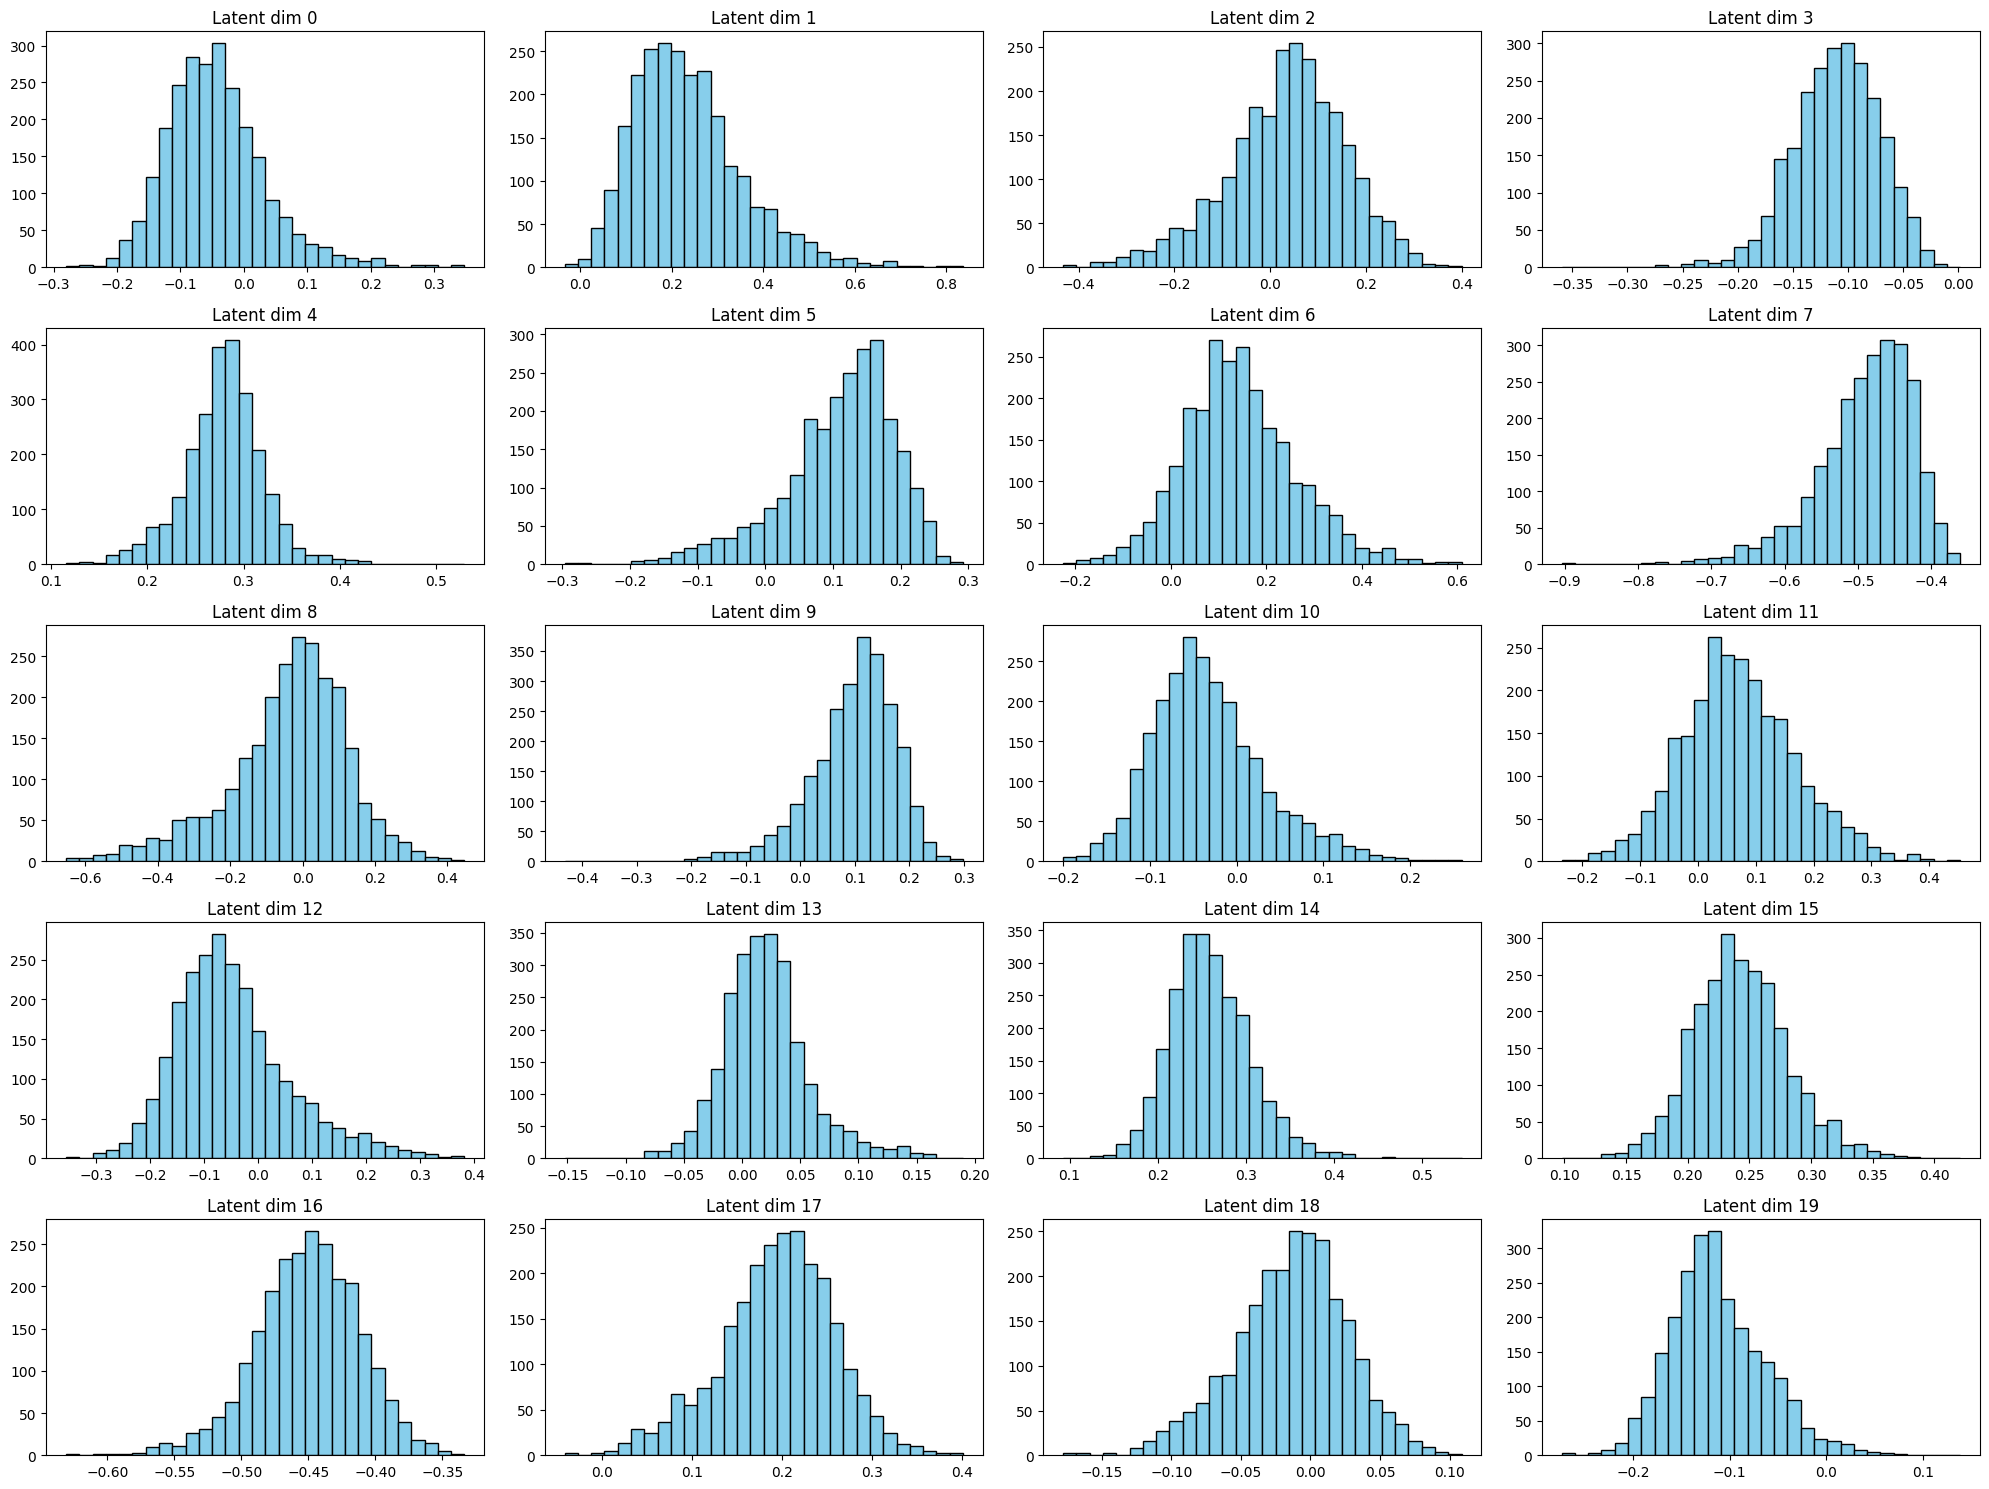

In [191]:
analyze_latent_components(old_latent_full, top_k=5)

Method 2

In [186]:
r2_df_full = method_2(structured_data_2, moral_only=False)

# View top traits best explained by latent dimensions
r2_df_full.sort_values(by="r2_score", ascending=False).head(10)

,trait_index,r2_score,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,...,latent_10,latent_11,latent_12,latent_13,latent_14,latent_15,latent_16,latent_17,latent_18,latent_19
85,trait_85,0.311182,-761.853516,-45.732300,232.331879,46.569656,172.861572,667.333069,520.796265,586.212280,...,7.198344,261.729309,659.497375,1009.556824,-1121.266602,-485.868530,-651.722351,-201.939178,-614.301758,97.992447
152,trait_152,0.311092,14.787584,297.347870,-6.707277,-1018.467407,-253.049820,175.191299,37.327869,388.150787,...,-29.243889,152.546494,-295.052429,164.806534,475.585175,-165.961014,174.276047,-36.624298,157.879150,-794.556885
108,trait_108,0.257698,412.281281,112.371017,52.043159,342.420044,43.771030,-379.220581,-369.953827,-436.472107,...,-71.116928,-301.975830,-376.039154,-520.342407,318.623596,314.707397,294.775543,-114.201843,410.991516,143.329361
110,trait_110,0.246410,-347.946716,-112.357613,-34.171883,-236.044830,-16.975901,297.367188,404.686249,478.807556,...,-111.933266,353.071869,481.797180,585.656189,-506.986084,-356.806732,-552.906738,103.585594,-708.188599,-202.074448
264,trait_264,0.245815,214.054459,-563.593384,-555.087036,653.173889,272.156403,-708.160034,361.791534,118.359100,...,-200.890472,198.305832,739.411560,115.135574,-406.734924,193.172256,-98.770058,1001.414917,-500.082916,-34.999615
11,trait_11,0.233355,537.447632,275.899963,-333.041229,-532.872070,-466.021667,-423.331696,-379.896118,-69.696915,...,193.582397,43.185368,-907.841553,-1059.746094,1479.648804,430.925385,660.472717,236.349472,841.796814,-305.474396
93,trait_93,0.231318,-65.877510,76.405411,285.641479,254.612305,395.147675,-131.594955,432.252594,504.385223,...,-0.122887,-126.225914,345.643250,736.911499,-827.133423,137.706589,-485.014587,-45.084255,-143.861557,-485.548553
263,trait_263,0.228309,26.595932,58.314537,334.348724,536.243530,346.389282,50.205055,9.131976,-200.925766,...,-26.124224,-206.927155,30.060270,195.591080,-613.962830,30.697401,-76.490326,-246.353699,22.667639,23.119810
325,trait_325,0.215175,166.091614,218.792404,-33.945930,-515.140686,-355.972809,88.842644,-390.697327,-288.140259,...,-95.147026,34.790550,-581.810913,-599.044434,788.366028,-74.779198,393.838715,-164.214691,252.934708,-29.482996
91,trait_91,0.213636,414.044403,114.558044,-33.285538,-231.229614,-77.351311,-63.344353,-633.935486,-558.466003,...,-230.727829,-177.335327,-464.764893,-464.651306,608.029297,40.747868,410.524902,-44.368866,82.812485,412.079620


- Trait 85: Direct/Roundabout
- Trait 152: Philosophical/Real
- Trait 108: Sickly/Healthy
- Trait 110:  Vain/Demure
- Trait 264: 🥾	/ 👟
- Trait 11: Innocent/Worldly
- Trait 93:  Hipster/Basic
- Trait 263: 🧗	/ 🛌
- Trait 325: Ppunk Rock/Preppy
- Trait 91: Charming/Trusting

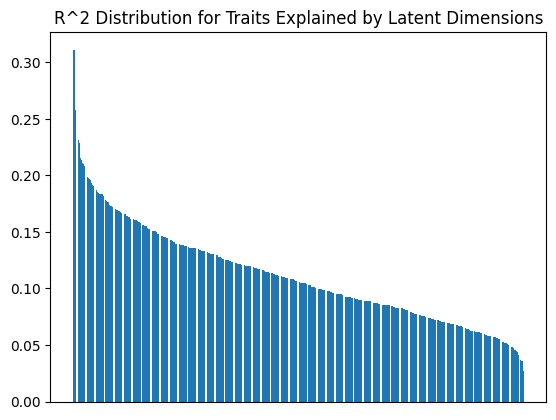

In [187]:
r2_df_full_sorted = r2_df_full.sort_values(by="r2_score", ascending=False)

plt.bar(r2_df_full_sorted["trait_index"], r2_df_full_sorted["r2_score"])
plt.xticks([])
plt.title("R^2 Distribution for Traits Explained by Latent Dimensions")
plt.show()